In [1]:
pwd

'/Users/edwardterrell/Desktop/Training/kindle/strava'

In [30]:
%matplotlib inline
from IPython.core.display import HTML
css = open('css/style-table.css').read() + open('css/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [10]:
import requests
import json
import time
import os
from pprint import pprint
import datetime

import pandas as pd
pd.set_option('display.precision', 1)
import warnings
warnings.filterwarnings("ignore", message=".*will drop timezone.*")

%load_ext autoreload
%autoreload 2
from clean_convert import cleanup, convert_speed, order_columns, process_new_data
from zones import get_zones_for_id, build_week_summary

# import graphics programs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,6)}) # for all future plots

import sys
sys.executable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/edwardterrell/opt/anaconda3/envs/mlml/bin/python'

In [4]:
from token_manager import get_valid_access_token
import requests

access_token = get_valid_access_token()
print("Using access token:", access_token)

# Make an authenticated API call
response = requests.get(
    'https://www.strava.com/api/v3/athlete',
    headers={'Authorization': f'Bearer {access_token}'}
)
print(response.json())

Access token expired. Refreshing...
Using access token: 980f79f6b681506ceb99e4b45543a1b6f3663590
{'id': 723727, 'username': 'eterrell', 'resource_state': 2, 'firstname': 'Ed', 'lastname': 'Terrell', 'bio': '', 'city': 'Boulder', 'state': 'CO', 'country': 'United States', 'sex': 'M', 'premium': True, 'summit': True, 'created_at': '2012-07-05T00:04:09Z', 'updated_at': '2025-07-09T12:38:59Z', 'badge_type_id': 1, 'weight': 61.235, 'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/medium.jpg', 'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/large.jpg', 'friend': None, 'follower': None}


In [5]:
# establish an empty strava_df and strava_zone_df for building-up from scratch 
# used when no previous data is do be loaded e.g. different user, different year
columns =['id', 'name', 'date', 'sport', 'distance', 'time', 'speed', 'elev_gain',
       'avg_HR', 'max_HR', 'suffer_score', 'time-minutes', 'average_speed',
       'start_date']
strava_df = pd.DataFrame(columns=columns)

columns = ['id', 'name', 'date', 'suffer_score', 'start_date', 'Zone1', 'Zone2',
       'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense', 'week_start',
       'weekly_intense', 'weekly_moderate', 'weekly_suffer_score']
strava_zone_df = pd.DataFrame(columns=columns)

In [6]:
# select year for pickle file 
# Reload dfs and confirm lengths
strava_df = pd.read_pickle("data/strava_data_2025.pkl")
strava_zone_df = pd.read_pickle("data/strava_zone_data_2025.pkl")

print(len(strava_df))
print(len(strava_zone_df))

121
121


In [7]:
# last entry date
strava_zone_df.head(1)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
0,15102156207,Recovery gravel in the early morning,2025-07-13,52.0,2025-07-13 13:09:14+00:00,3.8,117.1,0.1,0.5,3.5,120.9,4.1,2025-07-07,155.5,767.9,546.0


### Recent activities only!

In [9]:
# select date to start new activities data collection
startdate_string = '2025-07-01'
enddate_string = '2026-02-10'

# change date to unix integer format
start_date = int(time.mktime(time.strptime(startdate_string, '%Y-%m-%d')))
end_date = int(time.mktime(time.strptime(enddate_string, '%Y-%m-%d')))

# strava url
url = "https://www.strava.com/api/v3/athlete/activities"
headers = {"Authorization": f"Bearer {access_token}"}
params = {
    "after": start_date,
    "per_page": 200,  # max per request
    "page": 1
}
activities = []

stop_fetching = False
while True:
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data or stop_fetching:
        # breaks out of while loop
        break
        
    for activity in data:
        # change date to unix integer format
        activity_date = int(datetime.datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ").timestamp())

        # print(activity['start_date'])
        print(activity_date)
        if activity_date >= end_date:
            stop_fetching = True
            # breaks out of for loop only
            break 
        # set number of activites (strava maximum is 100/15 minutes)
        if len(activities) >= 30:
            stop_fetching = True
            # breaks out of for loop only
            break
        activities.append(activity)
    params["page"] += 1


# Build out strava_df with only the necessary columns
recent_df = pd.DataFrame(activities)
cols_needed = ['id','name', 'distance', 'moving_time','total_elevation_gain', 'sport_type',
          'average_speed', 'average_heartrate','max_heartrate', 'suffer_score','start_date']
recent_df = recent_df.loc[:,cols_needed]
recent_df = recent_df.sort_values('start_date',ascending=False) 

# This step does the comparison between recent_df and strava_df
# strava_df holds previously saved data

if strava_df.empty:
    new_activities_df = recent_df.copy()
else:
    new_activities_df = recent_df[~recent_df.id.isin(strava_df.id)].copy()
new_activities_df

1751399910
1751658397
1751745337
1751832882
1751913518
1752007442
1752092248
1752349547
1752433754
1752608348


,id,name,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_heartrate,max_heartrate,suffer_score,start_date
9,15123570047,North Sky and Skyline Ranch,47705.6,9659,429.9,Ride,4.9,109.3,138.0,77.0,2025-07-15T13:39:08Z


In [11]:
strava_df = process_new_data(new_activities_df, strava_df)

In [12]:
strava_df.head(1)

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
9,15123570047,North Sky and Skyline Ranch,2025-07-15,Ride,29.6,2:40,11.0,1410.4,109.3,138.0,77.0,161.0,4.9,2025-07-15 13:39:08+00:00


In [13]:
new_activities_df.id

9    15123570047
Name: id, dtype: int64

In [14]:
# Recent zone data
# Create a new_zone dataframe for recent activities
cols = ['id', 'name', 'date', 'suffer_score','start_date']
new_data = strava_df.loc[:,cols]
new_zone_df = pd.DataFrame(new_data, columns=cols)

mask = new_zone_df['id'].isin(new_activities_df['id'])
new_zone_df = new_zone_df[mask]

In [15]:
zone = new_zone_df['id'].apply(lambda current_id: get_zones_for_id(current_id, access_token))
zone.index = new_zone_df['id']

# Add in summary zones: moderate and intense
zone['moderate'] = zone[['Zone1', 'Zone2']].sum(axis=1)
zone['intense'] = zone[['Zone3', 'Zone4', 'Zone5']].sum(axis=1)
zone

Fetching zones for activity: 15123570047


,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense
id,,,,,,,
15123570047,8.3,139.5,13.1,0.0,0.0,147.9,13.1


In [16]:
new_zone_df = pd.merge(new_zone_df, zone, left_on='id',right_index=True)

In [17]:
# Get the Sunday start of the week for each date (time set to midnight)
new_zone_df['week_start'] = new_zone_df['start_date'].dt.to_period('W-SUN').dt.start_time

#new_zone_df.columns are now matched with strava_zone_df
new_zone_df = pd.concat ([new_zone_df, strava_zone_df], axis=0)

In [18]:
new_zone_df.head(1)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
9,15123570047,North Sky and Skyline Ranch,2025-07-15,77.0,2025-07-15 13:39:08+00:00,8.3,139.5,13.1,0.0,0.0,147.9,13.1,2025-07-14,NaN,NaN,NaN


In [19]:
# This drops all weekly_ cols since they are all recalculated later
only_cols = ['id', 'name', 'date', 'suffer_score', 'start_date', 'Zone1', 'Zone2',
       'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense', 'week_start']
new_zone_df = new_zone_df[only_cols]
#new_zone_df.head()

# Temporarily sort ascending by week_start and date to compute cumulative sum correctly
temp = new_zone_df.sort_values(['week_start', 'start_date'])

In [20]:
# Calculate cumulative sum within each week for weekly_ cols
cumulative_cols = ['intense', 'moderate', 'suffer_score']
cumulative_sums = (
temp
    .groupby('week_start')[cumulative_cols]
    .cumsum()
    .add_prefix('weekly_')  # rename columns if needed
)
# Add start_date column for reference
cumulative_sums['start_date'] = temp['start_date']
cumulative_sums = cumulative_sums.sort_values('start_date', ascending = False)
cumulative_sums.head(3)
strava_zone_df = pd.merge(new_zone_df,cumulative_sums, left_on ='start_date', right_on='start_date')

### Plotting Section

In [21]:
strava_zone_df.head()

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
0,15123570047,North Sky and Skyline Ranch,2025-07-15,77.0,2025-07-15 13:39:08+00:00,8.3,139.5,13.1,0.0,0.0,147.9,13.1,2025-07-14,13.1,147.9,77.0
1,15102156207,Recovery gravel in the early morning,2025-07-13,52.0,2025-07-13 13:09:14+00:00,3.8,117.1,0.1,0.5,3.5,120.9,4.1,2025-07-07,155.5,767.9,546.0
2,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,233.0,2025-07-12 13:45:47+00:00,22.3,222.0,82.0,1.6,0.0,244.3,83.6,2025-07-07,151.4,647.0,494.0
3,15061307314,Nederland exploration and exploitation,2025-07-09,106.0,2025-07-09 14:17:28+00:00,31.9,132.7,29.4,0.0,0.0,164.6,29.4,2025-07-07,67.8,402.8,261.0
4,15048399185,Jamestown and eats at Lucky's Bakery,2025-07-08,101.0,2025-07-08 14:44:02+00:00,21.4,109.4,26.1,0.8,0.0,130.8,26.9,2025-07-07,38.4,238.2,155.0


In [22]:
week_summary = build_week_summary(strava_zone_df)
week_summary.sort_values('week_start',ascending=False).head()

,week_start,weekly_intense,weekly_moderate,weekly_suffer_score,week
27,2025-07-14,13.1,147.9,77.0,Jul 14
26,2025-07-07,155.5,767.9,546.0,Jul 07
25,2025-06-30,143.9,794.7,597.0,Jun 30
24,2025-06-23,259.7,479.1,662.0,Jun 23
23,2025-06-16,240.2,554.1,668.0,Jun 16


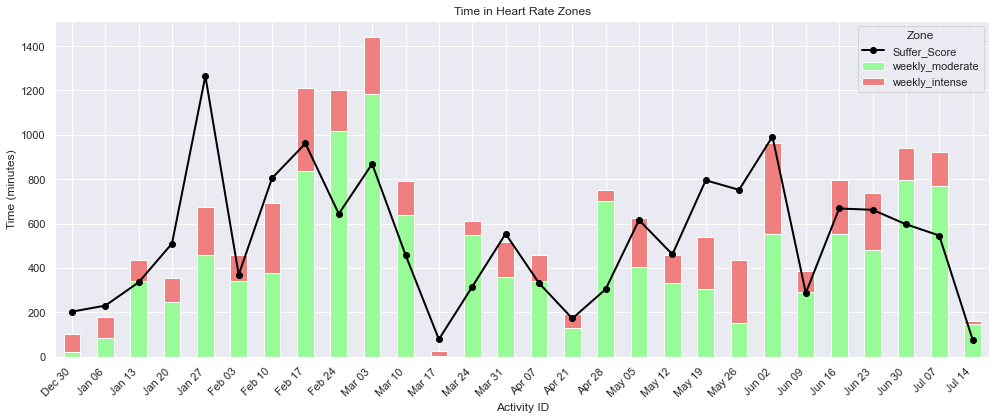

In [23]:
import matplotlib.pyplot as plt

ax = week_summary.plot(
    y=['weekly_moderate','weekly_intense'],
    x='week',
    kind='bar', 
    stacked=True, 
    figsize=(14, 6), 
    color=['#98FB98', '#F08080']
)

# Overlay line plot for 'weekly_suffer_score'
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="black",
    marker="o",
    linewidth=2,
    label="Suffer_Score"  
)

plt.title("Time in Heart Rate Zones")
plt.xlabel("Activity ID")
plt.ylabel("Time (minutes)")
plt.legend(title="Zone")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
# Melt the DataFrame to long format and plot
long_df = pd.melt(
    week_summary,
    id_vars="week",
    value_vars=["weekly_intense", "weekly_moderate"],
    var_name="zone",
    value_name="minutes"
)

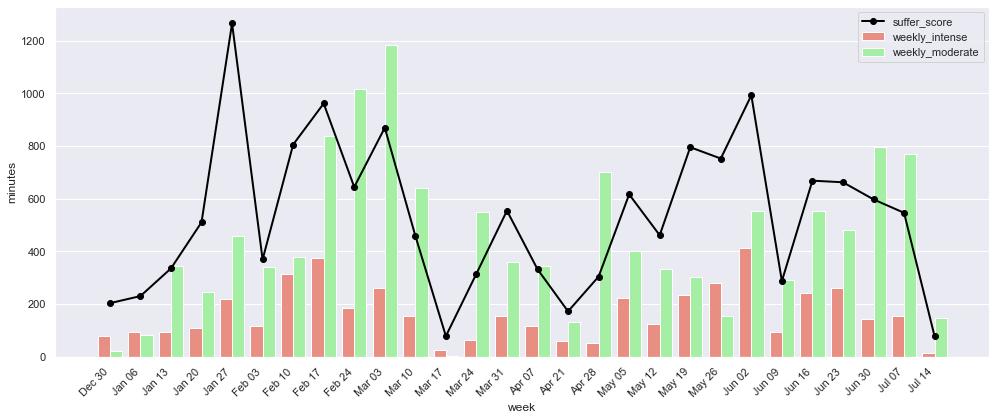

In [25]:
# Add a line plot on top 
plt.figure(figsize=(14, 6))
# Add line plot with a label
ax = sns.barplot(
    data=long_df,
    x="week",
    y="minutes",
    hue="zone",
    palette={"weekly_intense": "salmon", "weekly_moderate": "palegreen"}
)
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="black",
    marker="o",
    linewidth=2,
    label="suffer_score"  
)
# Create the legend manually from all handles
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

# Optional: improve layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.legend()
plt.show()

In [26]:
strava_df.head(1)

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
9,15123570047,North Sky and Skyline Ranch,2025-07-15,Ride,29.6,2:40,11.0,1410.4,109.3,138.0,77.0,161.0,4.9,2025-07-15 13:39:08+00:00


In [27]:
strava_zone_df.head(1)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
0,15123570047,North Sky and Skyline Ranch,2025-07-15,77.0,2025-07-15 13:39:08+00:00,8.3,139.5,13.1,0.0,0.0,147.9,13.1,2025-07-14,13.1,147.9,77.0


In [28]:
print(len(strava_df))
print(len(strava_zone_df))

122
122


In [29]:
# Save both
strava_df.to_pickle("data/strava_data_2025.pkl")
strava_zone_df.to_pickle("data/strava_zone_data_2025.pkl")

print("All data saved.")

All data saved.
